/tmp/ipykernel_3769/445420159.py:119: RuntimeWarning: divide by zero encountered in log
  return -((self.hits * np.log(hit_rate)) + (self.misses * np.log(1-hit_rate)) + (self.false_alarms * np.log(false_alarm_rate)) + (self.correct_rejections * np.log(1-false_alarm_rate)))


Estimated a: 0.8795523291464913 (0.35003803675432865, 1.4612552167309292)


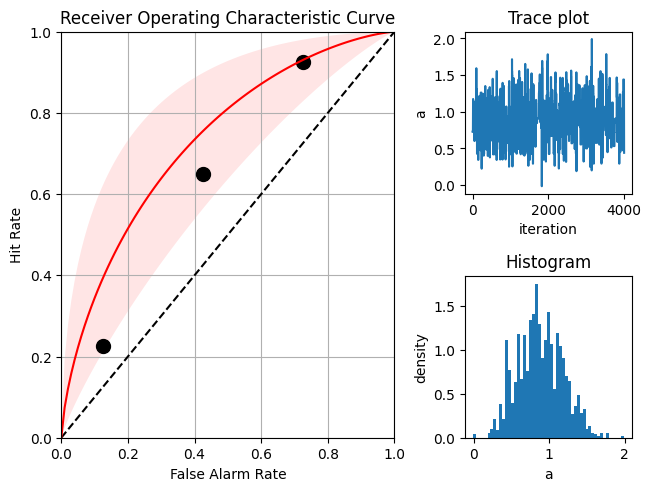

In [14]:
import numpy as np
import scipy.stats

class Metropolis:
    def __init__(self, logTarget, initialState):
        self.logTarget = logTarget
        self.state = initialState
        self.sigma = 1
        self.samples = []

    def _accept(self, proposal):
        p_curr = self.logTarget(self.state)
        p_proposal = self.logTarget(proposal)
        acceptance_probability = min(1, np.exp(p_proposal - p_curr))
        return np.random.uniform(0, 1) < acceptance_probability

    def adapt(self, blockLengths):
        for blockLength in blockLengths:
            acceptances = 0
            for _ in range(blockLength):
                proposal = np.random.normal(self.state, self.sigma)
                if self._accept(proposal):
                    self.state = proposal
                    acceptances += 1
            acceptance_rate = acceptances / blockLength
            self.sigma *= (0.4 / acceptance_rate)
        return self

    def sample(self, nSamples):
        for _ in range(nSamples):
            proposal = np.random.normal(self.state, self.sigma)
            if self._accept(proposal):
                self.state = proposal
            self.samples.append(self.state)
        return self

    def summary(self):
        mean = np.mean(self.samples)
        c025, c975 = np.percentile(self.samples, [2.5, 97.5])
        return {'mean': mean, 'c025': c025, 'c975': c975}

import scipy as spi
import matplotlib.pyplot as plt

class SignalDetection:
    
    def __init__(self, hits, misses, false_alarms, correct_rejections):
        self.hits = hits
        self.misses = misses
        self.false_alarms = false_alarms
        self.correct_rejections = correct_rejections
    
    def H(self):
        return (self.hits / (self.hits + self.misses))

    def FA(self):
        return (self.false_alarms / (self.false_alarms + self.correct_rejections))

    def d_prime(self):
        return (spi.stats.norm.ppf(self.H()) - spi.stats.norm.ppf(self.FA()))

    def criterion(self):
        return ((-0.5) * (spi.stats.norm.ppf(self.H()) + spi.stats.norm.ppf(self.FA())))
    
    def __add__(self, other):
        return SignalDetection(self.hits + other.hits, self.misses + other.misses, self.false_alarms + other.false_alarms, self.correct_rejections + other.correct_rejections)
    
    def __mul__(self, scalar):
        return SignalDetection(self.hits * scalar, self.misses * scalar, self.false_alarms * scalar, self.correct_rejections * scalar)
    
    @staticmethod
    def simulate(dprime, criteriaList, signalCount, noiseCount):
      sdtList = []
      for i in range(len(criteriaList)):
          k = criteriaList[i] + (dprime/2)
          hits, falseAlarms = np.random.binomial(n=[signalCount, noiseCount], p=[1 - spi.stats.norm.cdf(k - dprime),1 - spi.stats.norm.cdf(k)])
          misses, correctRejections = signalCount - hits, noiseCount - falseAlarms
          sdtList.append(SignalDetection(hits, misses, falseAlarms, correctRejections))
      
      return sdtList

    @staticmethod
    def plot_roc(sdtList):
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel("False Alarm Rate")
        plt.ylabel("Hit Rate")
        plt.title("Receiver Operating Characteristic Curve")
        if isinstance(sdtList, list):
            for i in range(len(sdtList)):
                s = sdtList[i]
                plt.plot(s.FA(), s.H(), 'o', color = 'black', markersize = 10)
        else:
            plt.plot(sdtList.FA(), sdtList.H(), 'o', color = 'black', markersize = 10)
        x, y = np.linspace(0,1,100), np.linspace(0,1,100)
        plt.plot(x,y, '--', color = 'black')
        plt.grid()

    def plot_sdt(self):
        noise_x = np.arange(-4, 4, 0.1)
        noise_y = spi.stats.norm.pdf(noise_x, 0, 1)
        signal_x = np.arange(-4, 4, 0.1)
        signal_y = spi.stats.norm.pdf(noise_x, self.d_prime(), 1)
        plt.plot(noise_x, noise_y, label = "Noise", color = 'blue')
        plt.plot(signal_x, signal_y, label = "Signal", color = 'green')
        plt.axvline(x = ((self.d_prime() / 2) + self.criterion()), label = "k", color = 'r', linestyle = '--')
        x_distance = [0, self.d_prime()]
        y_distance = [0.4, 0.4]
        plt.plot(x_distance, y_distance, '--', label = "Distance", color = 'black')
        plt.plot(0,0, 'o', label = '0', color = 'blue')
        plt.plot(self.d_prime(), 0, 'o', label = 'D\'', color = 'green')
        plt.title("Signal Detection Theory Curve")
        plt.xlabel("Response")
        plt.ylabel("Probability")
        plt.legend()
        plt.show()

    def nLogLikelihood(self, hit_rate, false_alarm_rate):
        return -((self.hits * np.log(hit_rate)) + (self.misses * np.log(1-hit_rate)) + (self.false_alarms * np.log(false_alarm_rate)) + (self.correct_rejections * np.log(1-false_alarm_rate)))

    @staticmethod
    def rocCurve(falseAlarmRate, a):
        return spi.stats.norm.cdf(a + spi.stats.norm.ppf((falseAlarmRate)))
    
    @staticmethod
    def fit_roc(sdtList):
        SignalDetection.plot_roc(sdtList)
        a = 0
        minimize = spi.optimize.minimize(fun = SignalDetection.rocLoss, x0 = a, method = 'nelder-mead', args = (sdtList))
        losscurve = []
        for i in range(0,100,1):
          losscurve.append((SignalDetection.rocCurve(i/100, float(minimize.x))))
        plt.plot(np.linspace(0,1,100), losscurve, '-', color='red')
        aHat = minimize.x
        return float(aHat)

    @staticmethod
    def rocLoss(a, sdtList):
        L = []
        for i in range(len(sdtList)):
            s = sdtList[i]
            predicted_hit_rate = s.rocCurve(s.FA(), a)
            L.append(s.nLogLikelihood(predicted_hit_rate, s.FA()))
            return sum(L)
        
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

def fit_roc_bayesian(sdtList):

    # Define the log-likelihood function to optimize
    def loglik(a):
        return -SignalDetection.rocLoss(a, sdtList) + scipy.stats.norm.logpdf(a, loc = 0, scale = 10)

    # Create a Metropolis sampler object and adapt it to the target distribution
    sampler = Metropolis(logTarget = loglik, initialState = 0)
    sampler = sampler.adapt(blockLengths = [2000]*3)

    # Sample from the target distribution
    sampler = sampler.sample(nSamples = 4000)

    # Compute the summary statistics of the samples
    result  = sampler.summary()

    # Print the estimated value of the parameter a and its credible interval
    print(f"Estimated a: {result['mean']} ({result['c025']}, {result['c975']})")

    # Create a mosaic plot with four subplots
    fig, axes = plt.subplot_mosaic(
        [["ROC curve", "ROC curve", "traceplot"],
         ["ROC curve", "ROC curve", "histogram"]],
        constrained_layout = True
    )

    # Plot the ROC curve of the SDT data
    plt.sca(axes["ROC curve"])
    SignalDetection.plot_roc(sdtList = sdtList)

    # Compute the ROC curve for the estimated value of a and plot it
    xaxis = np.arange(start = 0.00,
                      stop  = 1.00,
                      step  = 0.01)

    plt.plot(xaxis, SignalDetection.rocCurve(xaxis, result['mean']), 'r-')

    # Shade the area between the lower and upper bounds of the credible interval
    plt.fill_between(x  = xaxis,
                     y1 = SignalDetection.rocCurve(xaxis, result['c025']),
                     y2 = SignalDetection.rocCurve(xaxis, result['c975']),
                     facecolor = 'r',
                     alpha     = 0.1)

    # Plot the trace of the sampler
    plt.sca(axes["traceplot"])
    plt.plot(sampler.samples)
    plt.xlabel('iteration')
    plt.ylabel('a')
    plt.title('Trace plot')

    # Plot the histogram of the samples
    plt.sca(axes["histogram"])
    plt.hist(sampler.samples,
             bins    = 51,
             density = True)
    plt.xlabel('a')
    plt.ylabel('density')
    plt.title('Histogram')

    # Show the plot
    plt.show()

# Define the number of SDT trials and generate a simulated dataset
sdtList = SignalDetection.simulate(dprime       = 1,
                                   criteriaList = [-1, 0, 1],
                                   signalCount  = 40,
                                   noiseCount   = 40)

# Fit the ROC curve to the simulated dataset
fit_roc_bayesian(sdtList)